## Transfer Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, concatenate

In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [5]:
from PIL import Image
from tqdm import tqdm
import os

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
def plot_acc(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [9]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [10]:
image_dataset_path = "../Data/images_original/"

In [11]:
metadata = pd.read_csv('../Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [12]:
img_name = ''.join(metadata['filename'].iloc[0].split('.')[0:-1])+'.png'
img_name

'blues00000.png'

In [13]:
image = Image.open('../Data/images_original/blues/'+img_name).convert('RGB')

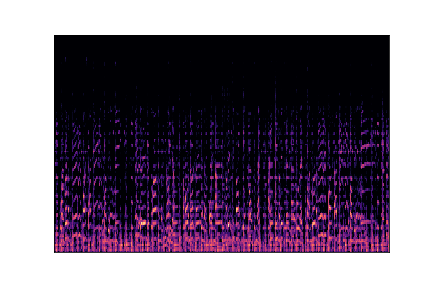

In [14]:
image

In [15]:
np.asarray(image).shape

(288, 432, 3)

In [16]:
image = image.resize((200, 150))
data = np.asarray(image)
data.shape

(150, 200, 3)

In [17]:
base_model = InceptionV3(input_shape=(150, 200, 3), include_top=False, weights="imagenet")

In [18]:
for layers in base_model.layers:
    layers.trainable = False

In [26]:
x = Flatten()(base_model.output)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

output = Dense(10, activation='softmax')(x)

model = Model(base_model.input, output)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

 batch_normalization_10 (BatchN  (None, 16, 22, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 22, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 22, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 22, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 22, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 22, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 22, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 22, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 10, 128)   98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 10, 128)  384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 10, 128)   0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 10, 128)   114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 10, 160)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 10, 160)   179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 10, 160)  480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 10, 160)   0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 10, 160)  480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 10, 160)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 10, 160)   122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 10, 160)   179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 10, 160)  480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 10, 192)   147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 10, 192)   258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 10, 192)  576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 10, 192)  576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 10, 192)  576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 10, 192)   0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 10, 192)   0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 4, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 4, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 4, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 4, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 4, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 4, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 4, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 4, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [27]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [28]:
train_generator = datagen.flow_from_directory(image_dataset_path, target_size=(200, 150), batch_size=20, subset='training')
val_generator = datagen.flow_from_directory(image_dataset_path, target_size=(200, 150), batch_size=20, subset='validation')

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [29]:
history = model.fit_generator(train_generator, steps_per_epoch=40, epochs=100, validation_data=val_generator, validation_steps=10)

Epoch 1/100


C:\Users\nihal\AppData\Local\Temp\ipykernel_15536\2816657482.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=40, epochs=100, validation_data=val_generator, validation_steps=10)


40/40 [==============================] - 8s 89ms/step - loss: 3.5158 - accuracy: 0.1225 - val_loss: 4.0934 - val_accuracy: 0.1709
Epoch 2/100
40/40 [==============================] - 2s 58ms/step - loss: 3.1691 - accuracy: 0.1737 - val_loss: 2.5628 - val_accuracy: 0.2362
Epoch 3/100
40/40 [==============================] - 2s 60ms/step - loss: 2.8983 - accuracy: 0.2050 - val_loss: 2.5904 - val_accuracy: 0.3116
Epoch 4/100
40/40 [==============================] - 2s 60ms/step - loss: 2.7734 - accuracy: 0.2050 - val_loss: 2.0740 - val_accuracy: 0.3367
Epoch 5/100
40/40 [==============================] - 2s 61ms/step - loss: 2.6123 - accuracy: 0.2600 - val_loss: 2.0197 - val_accuracy: 0.2714
Epoch 6/100
40/40 [==============================] - 3s 66ms/step - loss: 2.4625 - accuracy: 0.2600 - val_loss: 1.9396 - val_accuracy: 0.3417
Epoch 7/100
40/40 [==============================] - 3s 69ms/step - loss: 2.3194 - accuracy: 0.2950 - val_loss: 1.8779 - val_accuracy: 0.3568
Epoch 8/100
40/40 

40/40 [==============================] - 3s 74ms/step - loss: 1.2297 - accuracy: 0.5713 - val_loss: 2.5727 - val_accuracy: 0.4372
Epoch 59/100
40/40 [==============================] - 3s 71ms/step - loss: 1.2074 - accuracy: 0.5888 - val_loss: 2.9080 - val_accuracy: 0.3920
Epoch 60/100
40/40 [==============================] - 3s 74ms/step - loss: 1.2139 - accuracy: 0.5813 - val_loss: 3.0183 - val_accuracy: 0.4271
Epoch 61/100
40/40 [==============================] - 3s 81ms/step - loss: 1.2627 - accuracy: 0.5638 - val_loss: 3.4296 - val_accuracy: 0.3266
Epoch 62/100
40/40 [==============================] - 4s 90ms/step - loss: 1.3011 - accuracy: 0.5625 - val_loss: 3.2315 - val_accuracy: 0.4171
Epoch 63/100
40/40 [==============================] - 4s 94ms/step - loss: 1.3266 - accuracy: 0.5337 - val_loss: 3.4011 - val_accuracy: 0.3819
Epoch 64/100
40/40 [==============================] - 3s 81ms/step - loss: 1.2092 - accuracy: 0.5713 - val_loss: 3.0049 - val_accuracy: 0.4724
Epoch 65/100

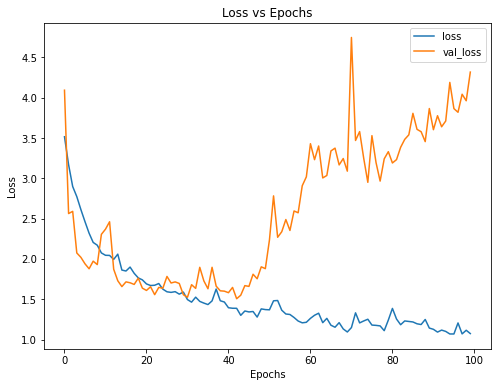

In [30]:
plot_loss(history)

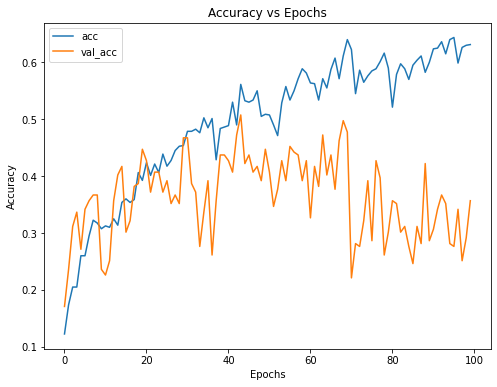

In [31]:
plot_acc(history)